**Протокол № 2 с Z распределениями участников за все циклы участия**

Протокол 2

Делаем пдф отчет с рисунками по всем аналитам для каждого участника 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model
import seaborn as sns

from fpdf import FPDF
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

"""
Скрипт для формирования протокола участника для фиксирования его динимики по циклам

"""



#load all file
num_cycle = 'c9'
cycle = 'Цикл 1 – 2021'
date_cycle = 'март 2021'
last_cycle = '2021_1'


df = pd.read_excel(r'C:/Users/ZhuravlevaR/MLPP/Z_score_Protokol2.xlsx', sheet_name=None)
df_c9 = pd.read_excel(r'C:/Users/ZhuravlevaR/MLPP/Z_score_Protokol2.xlsx', sheet_name=num_cycle)
dinamic = pd.read_excel(r'C:/Users/ZhuravlevaR/MLPP/dinamic.xlsx', sheet_name='Лист1')
df_all = pd.concat(df)
df_all.reset_index(drop = True, inplace =True)
analit_dic = pd.read_excel(r'C:/Users/ZhuravlevaR/MLPP/analit.xlsx')

analit_dic.index = analit_dic.iloc[:,0]
analit_dic.loc['rus','ALP'] = 'Щелочная фосфатаза, Е/л'
analit_dic.loc['rus','GGT'] = 'γ-Глутамилтрансфераза, Е/л'
analit_dic.loc['rus','Comp'] = 'Креатинин Яффе, с движущейся холостой пробой и комп. , мкмоль/л'

# update dinamic dataframe
analit = [] # list of analit
dic = {} # dict of short analit name

# переименовываю колонки по разным уровням аналитов
for name in dinamic.columns[1:]:
    if 'Unnamed' not in name:
        tmp = name
        analit += [tmp]
    dic.update({name : tmp + '_' + dinamic.at[0, name]})
dinamic = dinamic.rename(columns = dic)
dinamic = dinamic.iloc[1:]
dinamic.reset_index(drop = True, inplace =True)


# update dataframe for all cycles (2017-2021)
analit = [] # list of analit
dic = {} # dict of short analit name
for name in df_all.columns[3:]:
    if 'Unnamed' not in name:
        tmp = name
        analit += [tmp]
    dic.update({name : tmp + '_' + df_all.at[0, name]})
df_all = df_all.rename(columns = dic)
df_all = df_all.iloc[1:]
df_all.reset_index(drop = True, inplace =True)


# update dataframe for current cycle
analit_c9 = [] # list of analit
dic9 = {} # dict of short analit name
for name in df_c9.columns[3:]:
    if 'Unnamed' not in name:
        tmp = name
        analit_c9 += [tmp]
    dic9.update({name : tmp + '_' + df_c9.at[0, name]})
df_c9 = df_c9.rename(columns = dic9)
df_c9 = df_c9.iloc[1:]
df_c9.reset_index(drop = True, inplace =True)

# #drop rows if name == nan


df_SDI = df_all[pd.notnull(df_all['Code'])]
df_SDI.reset_index(drop = True, inplace =True)




In [2]:
# generate list of cycles

dinamic['cycle']=[ '2017_1', '2017_2', '2017_3', '2018_1',  '2018_2', '2019_1',  '2019_2', '2020_1', '2020_2', '2021_1'] * 2

In [3]:
# procedure for generate Z-score fig for 2017-2021

def figure(anal, code):
    """
    Процедура для формирования рисунка с Z распределением
    принимает название аналита и номер участника
    Сохраняет на диск готовый рисунок, который затем вставляется в протокол
    возвращает 1 при успешном формировании и 0 если нет данных для участника.
    """
    
    tmp = df_SDI[df_SDI.Code == code]
    t2 = pd.merge(tmp[[anal + '_Lev1', 'cycle']], dinamic[dinamic['type']=='mean'][[anal +'_Lev1', 'cycle']], on = 'cycle')
    t2 = pd.merge(t2, dinamic[dinamic['type']=='std'][[anal + '_Lev1', 'cycle']], on = 'cycle')
    t3 = pd.merge(tmp[[anal +'_Lev2', 'cycle']], dinamic[dinamic['type']=='mean'][[anal +'_Lev2', 'cycle']], on = 'cycle')
    t3 = pd.merge(t3, dinamic[dinamic['type']=='std'][[anal +'_Lev2', 'cycle']], on = 'cycle')

    t3['sdi1'] = (t2[anal +'_Lev1_x']-t2[anal +'_Lev1_y'])/t2[anal +'_Lev1']
    t3['sdi2'] = (t3[anal +'_Lev2_x']-t3[anal +'_Lev2_y'])/t3[anal +'_Lev2']
   
    # matching anomalies for Z-score above 3
    t3.loc[t3['sdi1'] > 3, 'sdi1'] = 3.5
    t3.loc[t3['sdi1'] < -3, 'sdi1'] = -3.5
    t3.loc[t3['sdi2'] > 3, 'sdi2'] = 3.5
    t3.loc[t3['sdi2'] < -3, 'sdi2'] = -3.5
    
    t3['color1'] = 'yes'
    t3.loc[abs(t3['sdi1']) > 3, 'color1'] = 'no'
    t3['color2'] = 'yes'
    t3.loc[abs(t3['sdi2']) > 3, 'color2'] = 'no'
  
    
    #print(((t2[anal + '_Lev1_x'][t2.cycle == last_cycle]).isnan())[0] ,  ((t3[anal + '_Lev2_x'][t3.cycle == last_cycle]).values==None)[0])
    if ((((t2[anal + '_Lev1_x'][t2.cycle == last_cycle]).values > 0)[0])) and  ((((t3[anal + '_Lev2_x'][t3.cycle == last_cycle]).values > 0)[0])):
        k = 1
    else:
        return 0

    fig, ax = plt.subplots(figsize = (7,5))
    x = [-1, 8.5]
    y1 = [1, 1]
    y2 = [2, 2]
    y3 = [3, 3]
    y4 = [-1, -1]
    y5 = [-2, -2]
    y6 = [-3, -3]
    plt.fill_between(x, y1, y2, color = 'grey', alpha = 0.2)
    plt.fill_between(x, y2, y3, color = 'grey', alpha = 0.6)
    plt.fill_between(x, y4, y5, color = 'grey', alpha = 0.2)
    plt.fill_between(x, y5, y6, color = 'grey', alpha = 0.6)
    sns.scatterplot(y=[0]*9, x = t2.cycle, ax=ax, s = 300, style=t3['color1'], color = 'green', legend=None, size=0, alpha = 0)
    markers = {"yes": "o", "no": "X"}
    sns.scatterplot(y=t3['sdi2'], x = t2.cycle, ax=ax, s = 500, style=t3['color2'], legend=None,markers=markers)
    sns.scatterplot(y=t3['sdi1'], x = t2.cycle, ax=ax, s = 500, style=t3['color1'], color = 'yellowgreen',  legend=None, markers=markers)
#     print(t3['color2'])
#     print(t3['color1'])
    plt.title(', '.join(analit_dic.loc['rus',anal].split(sep = ',')[0:-1]), size=16)
    ax.set_ylim(-3.99, 3.99)
    ax.set_xlim(-0.5, 8.5)
    plt.xlabel('')
    plt.ylabel('SDI', size=14)
    ax.axhline(y=0, color='k', linewidth=2, alpha = 0.2)

  #ax.fill_between(final_data[final_data['ProbeTime'].dt.month == month]['ProbeTime'],final_data[final_data['ProbeTime'].dt.month == month]['lab_value'].values-0.4,final_data[final_data['ProbeTime'].dt.month == month]['lab_value'].values+0.4), alpha=0.3)
    fig.savefig(r'C:/Users/ZhuravlevaR/MLPP/pics/2{}.png'.format(anal))
    return 1

<ipython-input-3-25cd42caf168>:27: RuntimeWarning: invalid value encountered in greater
  if ((((t2[anal + '_Lev1_x'][t2.cycle == last_cycle]).values > 0)[0])) and  ((((t3[anal + '_Lev2_x'][t3.cycle == last_cycle]).values > 0)[0])):


Е2


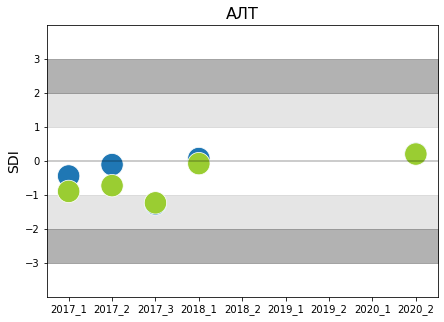

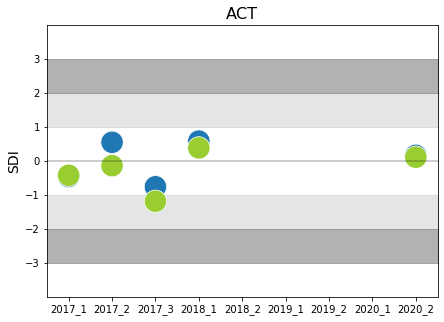

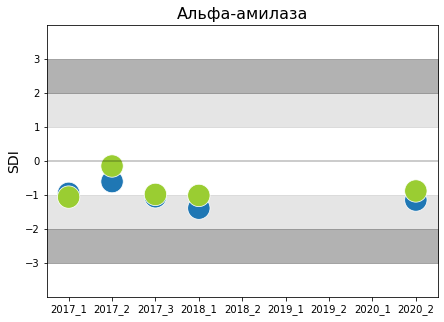

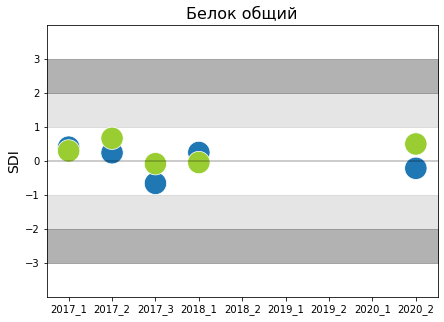

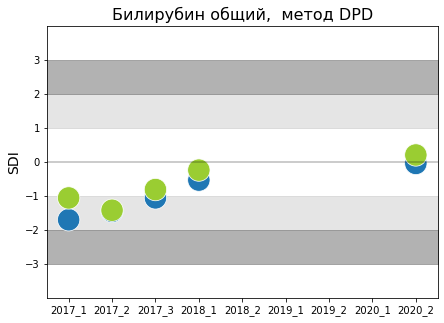

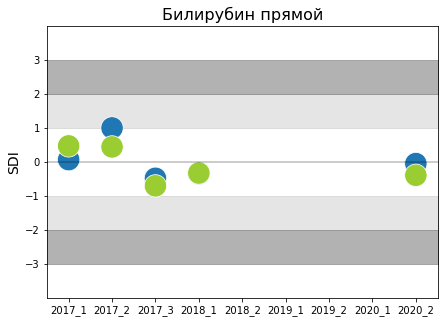

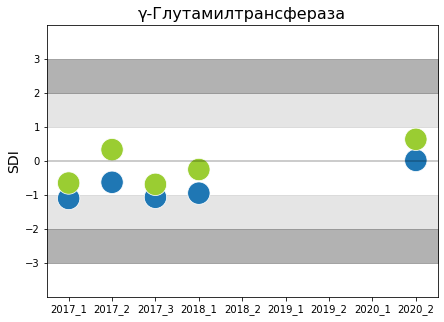

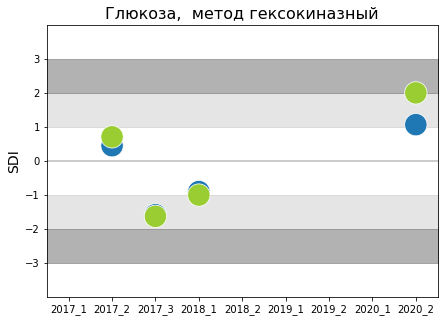

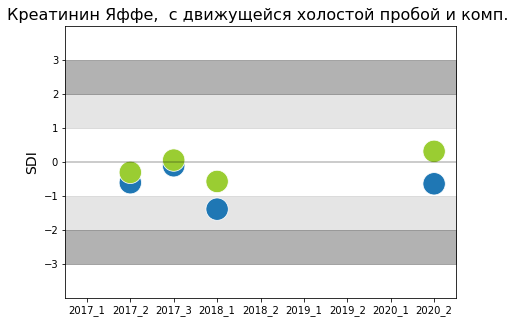

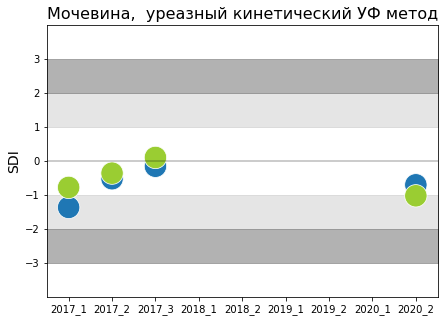

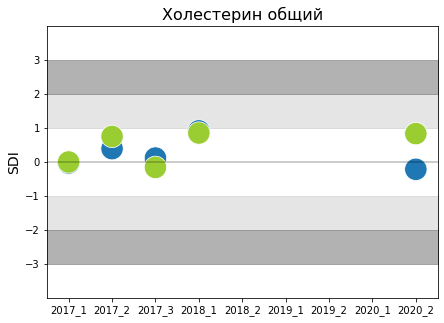

In [4]:
# THE MAIN PROCEDURE
# print to pdf protocol 

for number in range(60,61): # hand set numbers protocol print
    if df_c9.at[number,'ALT_Lev2'] > 0 or df_c9.at[number,'ALP_Lev2'] > 0 or df_c9.at[number,'Chol_Lev2'] > 0 or df_c9.at[number,'Prot_Lev2'] > 0 or df_c9.at[number,'CFK_Lev2'] > 0 :
        end_of_page = 240 # размер видимой части таблицы в мм
        pdf = FPDF() # создаю объет пдф и добовляю новую страницу
        pdf.add_page()
        # load RUS fonts
        pdf.add_font('DejaVuB', '', r'C:/Users/ZhuravlevaR/MLPP/FreeSerifBold.ttf', uni=True)
        pdf.add_font('DejaVu', '', r'C:/Users/ZhuravlevaR/MLPP/FreeSerif.ttf', uni=True)
        pdf.set_font('DejaVuB', '', 14)
        
        # load logo
        pdf.image(r'C:/Users/ZhuravlevaR/MLPP/Logotip.png', x=10, y=5, w=50)

        # head
        # создаю заголовок для протокола
        
        pdf.set_xy(10,20)
        pdf.write(15,'Межлабораторная программа-практикум по биохимическим исследованиям')

        pdf.set_font('DejaVu', '', 10)

        pdf.set_xy(10,25)
        pdf.write(25,'Код лаборатории')

        pdf.set_xy(40,33)
        pdf.set_fill_color(240, 230, 140)
        pdf.cell(15,8,df_all.Code[number],1,0,'C',1)
        

        pdf.set_xy(10,30)
        pdf.write(35,'ЛПУ')
        pdf.set_xy(25,44)
        pdf.set_fill_color(222, 222, 222)
        pdf.cell(160,8,df_all.Name[number],0,0,'L',1)

        text = """
    Показатель SDI (индекс среднеквадратического отклонения) отражает положение результата, полученного лабораторией, по отношению к результатам других участников. 
     Группы сравнения сформированы из результатов всех участников, выполнивших исследование одним методом, независимо от использованного оборудования.
      SDI вычислено по формуле: (X-ЦЗ)/S, где X – ваш результат, ЦЗ – целевое значение, рассчитанное по результатам, входящим в группу сравнения,  S – среднеквадратическое отклонение результатов.  Значения  SDI  ±1, ±2, ±3 соответствуют контрольным пределам ЦЗ ± 1S, ± 2S, ± 3S. 
        """
        pdf.set_xy(10,50)
        pdf.multi_cell(180,4.5,text,0,'C')
        
        # make and save figures 
        # добовляю после шапки таблицы общие легенды от рисунков
        pdf.set_xy(30,78)
        pdf.write(25,'уровень 1')
        pdf.image(r'C:/Users/ZhuravlevaR/MLPP/Lev1.png', x=24, y=94, w=4)
        pdf.set_xy(30,83)
        pdf.write(25,'уровень 2')
        pdf.image(r'C:/Users/ZhuravlevaR/MLPP/Lev2.png', x=24, y=89, w=4)
        pdf.set_xy(80,83)
        pdf.write(25,'результат за пределами ±3 SDI')
        pdf.image(r'C:/Users/ZhuravlevaR/MLPP/Lev3.png', x=74, y=94, w=4)
        
        # body of protocol
        # начинаю формировать рисунки
        i = 0
        y = 40
        
        # для фиксированных  аналитов формируем рисунки и добовляем на протокол
        for anal in ['Alb', 'ALT', 'AST', 'Amy', 'AmyP', 'Prot', 'DPD', 'BilE','BilK', \
                     'GGT', 'GOD', 'HEK', 'Fe',  \
                     'Crea', 'Comp', 'CFK', 'PAP','LDH', 'UA', 'Urea', 'TG', 'P', 'Chol', 'ALP']:
            # сразу в если пытаюсь сформировать и сохранить рисунок.
            # если рисунок не получился - нет данных, то переходимна другой аналит
            if figure(anal, df_all.Code[number]):
                y +=60 * ((i+1) % 2)
                if y > end_of_page:
                    pdf.add_page()
                    y = 25
                pdf.image(r'C:/Users/ZhuravlevaR/MLPP/pics/2{}.png'.format(anal), x=5 + 100 * (i%2), y=y, w=90) 
                i += 1


        # сохраняем сформированный протокол
        pdf.output(r"C:/Users/ZhuravlevaR/MLPP/MLPP_2020_2_Z/2020_2_{}_Протокол2.pdf".format(df_all.Code[number]), 'F')
        
        # отслеживаем статус выполнения протоколов
        print(df_all.Code[number])